# Baseline Solution - Monte Carlo Dropout

## This notebook documents the baseline solution for ADC 2022. 

## Overview
Our challenge is to provide 1. an error estimates (for Light Track) and/or 2. a conditional probability distribution (for Regular Track) for each target (6 in total) given an observation from the Ariel Space Telescope. The light track encourages a natural progression to the regular track. Participants are welcomed to join either or both tracks as they see fit. 

Depending on the information content of the observation and the associated observation noise (which is a function of the instrument and the planetary system), the resultant error bounds on each target and their joint conditional distribution will be different.

There are many directions you can take to tackle the problem on hand. We would like to get you started with our baseline solution. 

Spectroscopic data alone are usually informative enough to provide a reasonable estiamte on the targets. After all, the trough and peaks in the spectra encoded information about the relative abundance of each gaseous species (see [Yip et al.](https://iopscience.iop.org/article/10.3847/1538-3881/ac1744>) ). The supplementary information also helps to better constrain some of the phyiscal quantities (see our discussion [here](https://www.ariel-datachallenge.space/ML/documentation/about) if you want to learn about the underlying physics :) , but I shall leave that to you. 

The baseline solution trains a CNN to output a deterministic estimate for each atmospheric target. At inference time, the network is made to produce probabilistic output by activating the dropout layers in the network (Monte Carlo Dropout, [Gal et al. 2016](https://arxiv.org/abs/1506.02142)). 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import h5py
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Reshape, Input, Concatenate, BatchNormalization, Dropout, Conv1D,Flatten,MaxPooling1D
from keras.models import Model
from tqdm import tqdm
from helper import *
from preprocessing import *
from submit_format import *
from MCDropout import MC_Convtrainer

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## Constants

In [2]:
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000

## Read training data

In [3]:
training_path = '../NeurIPS_Competition/competition_script/data_generation/TrainingData2'

In [33]:
test_path = '../NeurIPS_Competition/competition_script/data_generation/TestData2'


In [4]:
training_GT_path = os.path.join(training_path, 'Ground Truth Package')

In [5]:
spectral_training_data = h5py.File(os.path.join(training_path,'SpectralData.hdf5'),"r")
aux_training_data = pd.read_csv(os.path.join(training_path,'AuxillaryTable.csv'))
soft_label_data = pd.read_csv(os.path.join(training_GT_path, 'FM_Parameter_Table.csv'))


## Extract Spectral data
Spectral data lives in a h5py format, which is useful for navigating different cases, but their format makes it difficult to bulk manage them. The helper function helps to transform the h5py file into a matrix of size N x 52 x 4
where N is the number of training examples, 52 is the number of wavelength channels and 4 is the observation data

In [6]:
spec_matrix = to_observed_matrix(spectral_training_data,aux_training_data)
print("spectral matrix shape:", spec_matrix.shape)

spectral matrix shape: (91392, 52, 4)


# Visualising a single spectrum

In [7]:
def visualise_spectrum(spectrum):
    fig = plt.figure(figsize=(10,6))
    plt.errorbar(x=spectrum[:,0], y= spectrum[:,1], yerr=spectrum[:,2] )
    ## usually we visualise it in log-scale
    plt.xscale('log')
    plt.show()

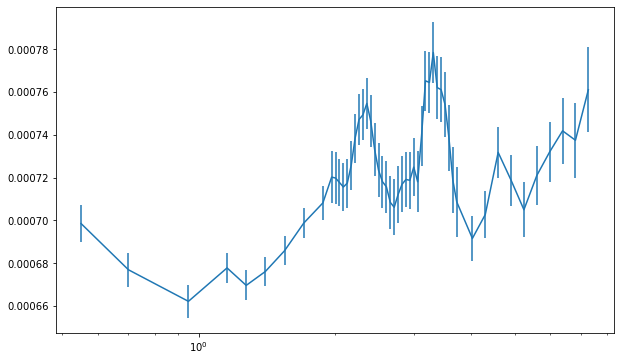

In [8]:
visualise_spectrum(spec_matrix[1])

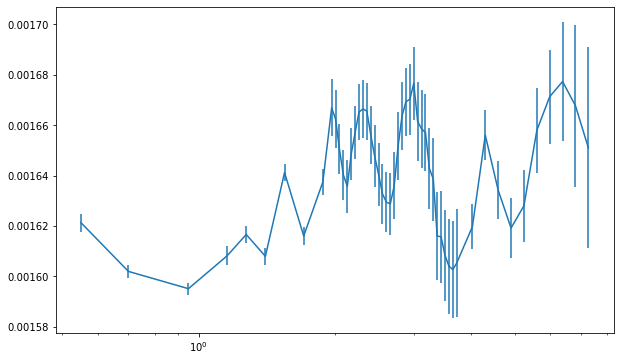

In [9]:
## lets look at another one
visualise_spectrum(spec_matrix[2])

it is immediately apparent that the average transit depth between two spectra can change for an order of magnitude difference. The magnitude of the uncertainty can also change accordingly ( and is a function of the planetary system, brightness of the host star and instrument response function). 

## Pre-processing

### Settings

In [10]:
repeat = 5
N = 5000 # train on the first 5000 data instances

We can safely discard wlgrid (wavelength grid) and wlwidth (width of wavelength) since they are unchanged in the dataset

In [11]:
## extract the noise
noise = spec_matrix[:N,:,2]
## We will incorporate the noise profile into the observed spectrum by treating the noise as Gaussian noise.
spectra = spec_matrix[:N,:,1]
wl_channels = len(spec_matrix[0,:,0])



### Augment the dataset with noise (create multiple instances)
Observational noise from Ariel forms an important part of the challenge, any model must recognise that the observation are not absolute measurement and could vary (according to the uncertainty), as that will affect the uncertainty associated with our atmospheric targets. Here we try to incorporate these information by augmenting the data with the mean noise.

In [22]:
aug_spectra = augment_data_with_noise(spectra, noise, repeat)

### Standardise the data

In [23]:
## standardise the input using global mean and stdev
global_mean = np.mean(spectra)
global_std = np.std(spectra)
std_aug_spectra = standardise(aug_spectra, global_mean, global_std)
std_aug_spectra = std_aug_spectra.reshape(-1, wl_channels)

### Add additional features - radius of the star and the planet
Most of the time we know something about the planetary system before we even attempt to make an observation (we cant just point randomly with a multi-million euros instrument!). Some of these auxillary data may be useful for retrieval, here we are only using the radius of the star and the planet.

In [14]:
## add Rstar and Rplanet
radii = aux_training_data[['star_radius_m', 'planet_radius_m']]
## we would prefer to use Rsol and Rjup 
radii['star_radius'] = radii['star_radius_m']/RSOL
radii['planet_radius'] = radii['planet_radius_m']/RJUP
radii = radii.drop(['star_radius_m', 'planet_radius_m'],axis=1)
radii = radii.iloc[:N, :]


/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_61987/773025397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radii['star_radius'] = radii['star_radius_m']/RSOL
/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_61987/773025397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radii['planet_radius'] = radii['planet_radius_m']/RJUP


In [26]:
## standardise
mean_radii = radii.mean()
stdev = radii.std()
std_radii= standardise(radii, mean_radii, stdev)
std_aug_radii = np.tile(std_radii.values,(repeat,1))

### augment target and standardise the output
We are asking the model to provide estimates for 6 atmospheric targets. In this example will be performing a supervised learning task. 

In [27]:
target_labels = ['planet_temp','log_H2O','log_CO2','log_CH4','log_CO','log_NH3']
targets = soft_label_data.iloc[:N][target_labels]
num_targets = targets.shape[1]
targets_mean = targets.mean()
targets_std = targets.std()
std_targets = standardise(targets, targets_mean, targets_std)

std_aug_targets = np.tile(std_targets.values,(repeat,1))

# Setup network


### hyperparameter settings


In [28]:
batch_size= 32
lr= 1e-3
epochs = 50
filters = [32,64,128]
dropout = 0.1
# number of examples to generate in test time
N_samples = 1000

We followed [Yip et al.](https://iopscience.iop.org/article/10.3847/1538-3881/ac1744>) and adopted a simple CNN structure and loss function. 


In [29]:
model = MC_Convtrainer(wl_channels,num_targets,dropout,filters)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 52)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 52, 1)        0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 50, 32)       128         ['reshape_1[0][0]']              
                                                                                                  
 conv1d_7 (Conv1D)              (None, 48, 32)       3104        ['conv1d_6[0][0]']               
                                                                                            

### Train-test split + shuffling

In [31]:
ind = np.random.rand(len(std_aug_spectra)) < 0.8
x_train_spectra, x_train_radii,y_train = std_aug_spectra[ind],std_aug_radii[ind],std_aug_targets[ind]
x_valid_spectra, x_valid_radii,y_valid = std_aug_spectra[~ind],std_aug_radii[~ind],std_aug_targets[~ind]



### Compile model and Train!

In [32]:
## compile model and run
model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss='mse',)
model.fit([x_train_spectra,x_train_radii], 
          y_train, 
          validation_data=([x_valid_spectra, x_valid_radii],y_valid),
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False,)


2022-06-27 11:37:04.165271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-06-27 11:37:04.374430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


626/626 [==============================] - ETA: 0s - loss: 0.9128

2022-06-27 11:37:09.028988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


626/626 [==============================] - 5s 8ms/step - loss: 0.9128 - val_loss: 0.8339
Epoch 2/50
626/626 [==============================] - 5s 8ms/step - loss: 0.6047 - val_loss: 0.4727
Epoch 3/50
626/626 [==============================] - 5s 8ms/step - loss: 0.4401 - val_loss: 0.4089
Epoch 4/50
626/626 [==============================] - 5s 8ms/step - loss: 0.3936 - val_loss: 0.3773
Epoch 5/50
626/626 [==============================] - 5s 7ms/step - loss: 0.3651 - val_loss: 0.3681
Epoch 6/50
626/626 [==============================] - 5s 7ms/step - loss: 0.3423 - val_loss: 0.3385
Epoch 7/50
626/626 [==============================] - 5s 7ms/step - loss: 0.3250 - val_loss: 0.3247
Epoch 8/50
626/626 [==============================] - 5s 7ms/step - loss: 0.3178 - val_loss: 0.3217
Epoch 9/50
626/626 [==============================] - 5s 8ms/step - loss: 0.3034 - val_loss: 0.3075
Epoch 10/50
626/626 [==============================] - 5s 8ms/step - loss: 0.2937 - val_loss: 0.3060
Epoch 11/5

## Read test data

In [34]:
spec_test_data = h5py.File(os.path.join(test_path,'SpectralData.hdf5'),"r")
aux_test_data = pd.read_csv(os.path.join(test_path,'AuxillaryTable.csv'))

In [35]:
test_spec_matrix = to_observed_matrix(spec_test_data,aux_test_data )


### same pre-processing as before...

In [36]:
std_test_spectra = standardise(test_spec_matrix[:,:,1], global_mean, global_std)


In [40]:
test_radii = aux_test_data[['star_radius_m', 'planet_radius_m']]
## we would prefer to use Rsol and Rjup 
test_radii['star_radius'] = test_radii['star_radius_m']/RSOL
test_radii['planet_radius'] = test_radii['planet_radius_m']/RJUP
test_radii = test_radii.drop(['star_radius_m', 'planet_radius_m'],axis=1)

std_test_radii= standardise(test_radii, mean_radii, stdev)


/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_61987/4112272106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_radii['star_radius'] = test_radii['star_radius_m']/RSOL
/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_61987/4112272106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_radii['planet_radius'] = test_radii['planet_radius_m']/RJUP


## Predict

In [41]:
instances = N_samples
y_pred_distribution = np.zeros((instances, len(std_test_spectra), num_targets ))
for i in tqdm(range(instances)):
    y_pred = model.predict([std_test_spectra,test_radii])
    y_pred_distribution[i] += y_pred


100%|████████████████████████████████████████████████████████████| 1000/1000 [03:30<00:00,  4.75it/s]


In [42]:
y_pred_distribution = y_pred_distribution.reshape(-1,num_targets)

In [43]:
## project back to original space
y_pred_org = transform_back(y_pred_distribution,targets_mean[None, ...], targets_std[None, ...])

/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_61987/1834157246.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred_org = transform_back(y_pred_distribution,targets_mean[None, ...], targets_std[None, ...])


In [44]:
y_pred_org = y_pred_org.reshape(instances, len(std_test_spectra), num_targets)
y_pred_org = np.swapaxes(y_pred_org, 1,0)

## Package output into desired format
We follow specific formats in the competition, to help make the process as painless as possible, we have included a few helper functions to make sure you have the right format in place for the submission. 

### Light Track

In [45]:
# extract quartiles estimate for 25th, 50th and 75th percentile.
all_q1_pred, all_q2_pred, all_q3_pred = np.quantile(y_pred_org, [0.25,0.5,0.75],axis=1)

In [46]:
LT_submission = to_light_track_format(all_q1_pred, all_q2_pred, all_q3_pred,planet_ID = aux_test_data.planet_ID.to_numpy())

100%|██████████████████████████████████████████████████████████| 2997/2997 [00:01<00:00, 2648.55it/s]


### Regular Track

In [50]:
RT_submission = to_regular_track_format(y_pred_org, np.ones((y_pred_org.shape[0],y_pred_org.shape[1])),planet_ID = aux_test_data.planet_ID.to_numpy() , name="RT_submission.hdf5")

## check!

In [51]:
LT_submission.head()

,planet_ID,T_q1,T_q2,T_q3,log_H2O_q1,log_H2O_q2,log_H2O_q3,log_CO2_q1,log_CO2_q2,log_CO2_q3,log_CH4_q1,log_CH4_q2,log_CH4_q3,log_CO_q1,log_CO_q2,log_CO_q3,log_NH3_q1,log_NH3_q2,log_NH3_q3
0,0,825.332080,878.290657,942.449059,-7.177890,-7.038731,-6.884780,-5.442977,-5.295634,-5.181637,-8.656517,-8.514310,-8.290215,-4.371682,-4.270828,-4.176752,-5.483807,-5.351410,-5.244115
1,1,1187.030331,1247.726114,1301.719760,-3.794218,-3.574868,-3.402123,-7.900368,-7.756982,-7.580616,-3.521477,-3.288742,-3.088727,-4.384785,-4.269717,-4.147293,-7.037421,-6.901933,-6.765866
2,2,1592.975586,1663.404828,1722.274775,-5.280249,-5.119221,-4.991702,-8.576526,-8.437302,-8.293725,-5.846811,-5.739428,-5.636470,-4.252140,-4.151899,-4.061889,-8.178223,-7.991701,-7.796022
3,3,998.907889,1043.918399,1098.985811,-7.129126,-6.972577,-6.777691,-8.023293,-7.877364,-7.720183,-8.124740,-7.943586,-7.667934,-5.002009,-4.888348,-4.782283,-4.493463,-4.314488,-4.186245
4,4,959.155503,1009.646621,1061.964253,-6.642290,-6.506898,-6.390639,-6.047331,-5.966457,-5.847030,-6.123262,-6.018521,-5.906574,-4.723613,-4.614586,-4.488041,-5.739378,-5.582783,-5.470683


In [52]:
RT_submission['Planet_0']['tracedata'][:].shape

(1000, 6)

## Future work

There are different direction to take from here on, let us summarise the shortcoming of this model:
- The data preprocessing is quite simplitic and could have invested more efforts.
- we have only used 5000 data points, instead of the full dataset
- we didnt train the model with results from the retrieval (QuartilesTable.csv for Light Track and Tracedata.hdf5 for Regular Track), which are the GT for this competition.
- The conditional distribution from MCDropout is very restricted and Gaussian-like
- So far we havent considered the atmospheric targets as a joint distribution
- We have only used stellar radius and planet radius from the auxillary information
- We have not done any hyperparameter tuning 
- the train test split here is not clean, as in, we split the data after we have augmented the data, which results in information leakage to the validation data. There is no leakage to the test data though.